In [1]:
import sys
import pandas as pd
import datetime as dt
import plotly.graph_objects as go
from plotting import CandlePlot

In [2]:
sys.path.append("../") # IS ZELFDE ALS sys.path.append("C:\\Users\\herma\\Documents\\Trading")

In [ ]:
sys.path

In [3]:
from infrastructure.instruments import Data

In [4]:
instr= Data()


In [5]:
pair = "EUR_USD"
granularity = "H1"
df = pd.read_pickle(f"../data/{pair}_{granularity}.pkl")
MA_LIST = [10,20,50,80,200]
pip = instr.instruments[pair]["pipLocation"]
pip

0.0001

In [6]:
df_ma = df[['time','mid_o', 'mid_h',
       'mid_l', 'mid_c']].copy()


In [7]:
for ma in MA_LIST:
    df_ma[f"MA_{ma}"]=df_ma.mid_c.rolling(window=ma).mean()
    df_ma.dropna(inplace=True)
    df_ma.reset_index(drop = True, inplace=True)
   



In [ ]:
df_ma

In [8]:
traces = [f"MA_{x}" for x in MA_LIST]

In [ ]:
traces


In [11]:
cp = CandlePlot(df_ma.iloc[0:500], candles = True)

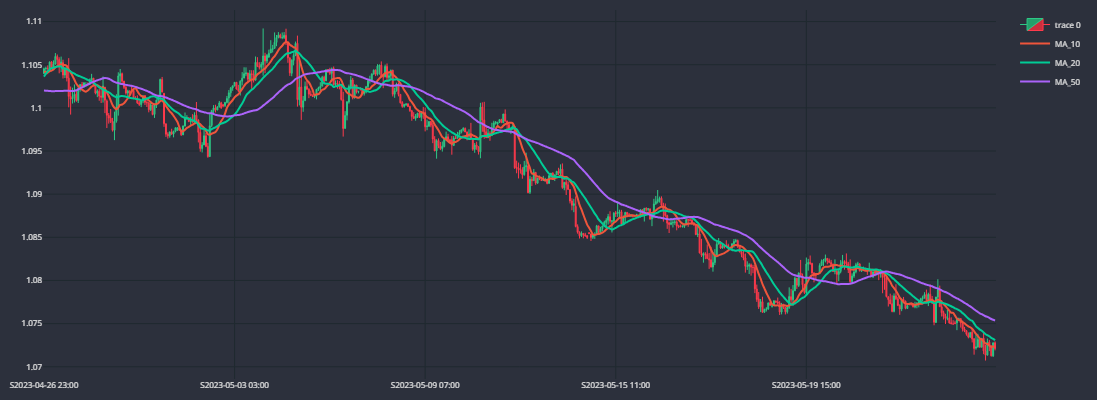

In [12]:
cp.show_plot(line_traces=["MA_10","MA_20","MA_50"])

In [ ]:
MA_S = "MA_10"
MA_M = "MA_20"
MA_L = "MA_50"
short_sell = 1
short_buy= -1
NONE = 0

In [ ]:
df_an = df_ma[['time','mid_o', 'mid_h','mid_l', 'mid_c', MA_S, MA_M,MA_L]].copy()

# diff method for colums : df_an["T"]= df_an.MA_50.diff(1)

#dropping columns: df_an.drop(columns ="trend", inplace =True) 

In [ ]:
df_an["DELTA_10_20"]= df_an["MA_10"]- df_an["MA_20"]



In [ ]:
df_an["DELTA_PREV_10_20"]= df_an["DELTA_10_20"].shift(1)
df_an["MA_50_PREV"]= df_an["MA_50"].shift(1)
df_an["DELTA_50"]= df_an["MA_50_PREV"]*1000- df_an["MA_50"]*1000



#df_an.dropna(inplace=True)


In [ ]:
df_an.columns


In [ ]:
df_an = df_an[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'MA_10', 'MA_20','MA_50_PREV', 'MA_50','DELTA_50','DELTA_PREV_10_20',
       'DELTA_10_20',]]


In [ ]:
def trend(row, delta =0.05):
    if  abs(row["DELTA_50"]) <= delta:
        return "NONE"
    elif row["MA_50_PREV"] - row["MA_50"] <= 0 :
        return "BUL"
    else:
       return "BEAR"

In [ ]:
df_an["TREND"] =df_an.apply(trend, axis =1)

In [ ]:
def is_short_trade (row):
    if  row["DELTA_PREV_10_20"] >= 0 and row["DELTA_10_20"] < 0 and row["TREND"] =="BEAR":        
        return 1 
    else:
        return 0

def is_long_trade (row):
    if  row["DELTA_PREV_10_20"] <= 0 and row["DELTA_10_20"] > 0 and row["TREND"] =="BUL":        
        return 1 
    else:
        return 0

    

In [ ]:
df_an["TRADE_SHORT"] = df_an.apply(is_short_trade, axis=1)
df_an["TRADE_LONG"] = df_an.apply(is_long_trade, axis=1)


In [ ]:
df_an.iloc[3500:3550]

In [ ]:
df_an["END_TRADE"]= df_an.mid_c.shift(-4)
df_an["RES_SHORT"] = (df_an["mid_c"] - df_an["END_TRADE"]) /pip *1
df_an["RES_LONG"] = (df_an["mid_c"] - df_an["END_TRADE"]) /pip *-1


In [ ]:
df_an.head(3)

In [ ]:
df_an.shape


In [ ]:
df_short_trades = df_an[df_an["TRADE_SHORT"] == 1].copy()
df_long_trades = df_an[df_an["TRADE_LONG"] == 1].copy()

In [ ]:
df_long_trades


In [ ]:
df_short_trades.columns


In [ ]:
df_short_trades = df_short_trades[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'MA_10', 'MA_20',
       'MA_50','TRADE_SHORT', 'END_TRADE', 'RES_SHORT','TREND']]
df_long_trades = df_long_trades[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'MA_10', 'MA_20',
       'MA_50','TRADE_LONG', 'END_TRADE', 'RES_LONG','TREND']]


In [ ]:
df_short_trades["cum"] = df_short_trades.RES_SHORT.cumsum()
df_long_trades["cum"] = df_long_trades.RES_LONG.cumsum()


In [ ]:
df_short_trades

In [ ]:
df_long_trades

In [ ]:
cp = CandlePlot(df_long_trades, candles = False)

In [ ]:

cp.show_plot(line_traces=["cum"])
